## Task 1 - Zero-Shot Evaluation

In [2]:
#@title GPU / Python / Torch sanity
import os, sys, subprocess, json, platform, torch
print("Python :", sys.version)
print("CUDA   :", torch.version.cuda)
print("Torch  :", torch.__version__)
print("Device :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
!nvidia-smi || true

Python : 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
CUDA   : 12.1
Torch  : 2.3.1+cu121
Device : NVIDIA GeForce RTX 4090
Tue Nov 11 16:18:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0 Off |                  Off |
| 38%   72C    P2            372W /  450W |   16847MiB /  24564MiB |     95%

In [3]:
# some imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from torchinfo import summary
from tqdm.autonotebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json
import torch.nn.functional as F
from PIL import Image
import os
from datasets import load_dataset
import io
from torchvision.datasets import Flowers102

import matplotlib.pyplot as plt
from typing import List, Optional
from tabulate import tabulate


/home/abat/conda_envs/clip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# 降噪：避免 tokenizers 在多工情境下噴警告
os.environ["TOKENIZERS_PARALLELISM"] = "false"

DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-large-patch14" # pre-trained CLIP model (ViT-L/14)
BATCH_SIZE = 64                               # 3080 10GB 建議 32~64；不足再降
NUM_WORKERS = 2

print(f"Python: {torch.__version__}, Device: {DEVICE}")

processor = CLIPProcessor.from_pretrained(MODEL_ID)
model     = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()




Python: 2.3.1+cu121, Device: cuda


/home/abat/conda_envs/clip/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [5]:
# ==== Flowers102 (torchvision) ====

# 把 PIL 影像轉成 (3,224,224) 的 CLIP 規格 tensor
def clip_image_transform(image):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.convert("RGB")
    px = processor(images=image, return_tensors="pt")["pixel_values"][0]  # (3,224,224)
    return px

flowers102_test_dts = Flowers102(
    root="./data",
    split="test",
    transform=clip_image_transform,
    download=True
)
print(f"Total test samples (Flowers102): {len(flowers102_test_dts)}")  # 6149

flowers102_test_loader = DataLoader(
    flowers102_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# 類別名稱（使用你上傳的 cat_to_name.json）
with open("./data/cat_to_name.json", "r") as f:
    cat_to_name = json.load(f)
flowers102_class_names = [cat_to_name[str(i)] for i in range(1, 103)]


Total test samples (Flowers102): 6149


In [6]:
# ==== CUB-200-2011 (HF datasets) ====


birds_200 = load_dataset("bentrevett/caltech-ucsd-birds-200-2011", cache_dir="./data")
cub_bird_test_raw = birds_200["test"]
print(f"Total test samples (CUB): {len(cub_bird_test_raw)}")  # 5794

def _to_pil_image_safe(img):
    """Robust convert HF dataset image (PIL/ndarray/list/bytes) -> PIL.Image."""
    if isinstance(img, Image.Image):
        return img
    if isinstance(img, np.ndarray):
        return Image.fromarray(img)
    # list may be list-of-ints (bytes) or nested lists (HWC)
    if isinstance(img, (list, tuple)):
        # list of ints -> bytes
        if all(isinstance(x, (int, np.integer)) for x in img):
            return Image.open(io.BytesIO(bytes(img)))
        # else try to convert to array (may raise ValueError for ragged)
        try:
            arr = np.asarray(img, dtype=np.uint8)
            return Image.fromarray(arr)
        except Exception as ex:
            raise TypeError(f"Cannot convert list image to PIL (ragged?): {ex}") from ex
    if isinstance(img, (bytes, bytearray)):
        return Image.open(io.BytesIO(img))
    raise TypeError(f"Unsupported image type for conversion to PIL: {type(img)}")

def cub_transform(example):
    """
    Accept both single example and batch-dict (where example['image'] is a list).
    Return pixel_values as numpy arrays (C,H,W) to keep HF formatting/collate stable.
    """
    def proc_one(img):
        pil = _to_pil_image_safe(img).convert("RGB")
        px = processor(images=pil, return_tensors="pt")["pixel_values"][0]  # tensor (3,224,224)
        return px.numpy()

    # batched call from datasets.formatting may pass lists
    if isinstance(example, dict) and isinstance(example.get("image"), (list, tuple)):
        imgs = [proc_one(im) for im in example["image"]]
        labs = list(example["label"])
        return {"pixel_values": imgs, "label": labs}
    # single example
    img = example["image"]
    px_arr = proc_one(img)
    return {"pixel_values": px_arr, "label": example["label"]}

cub_bird_test_dts = cub_bird_test_raw.with_transform(cub_transform)

# 強韌的 collate：把所有樣本疊成 (B,3,224,224)，label 成 (B,)
def _to_chw224(x: torch.Tensor) -> torch.Tensor:
    x = torch.as_tensor(x)
    if not torch.is_floating_point(x):
        x = x.float() / 255.0
    if x.ndim == 3:
        # HWC -> CHW
        if x.shape[-1] == 3 and x.shape[0] != 3:
            x = x.permute(2, 0, 1)
        # 灰階擴通道
        if x.shape[0] == 1:
            x = x.repeat(3, 1, 1)
        elif x.shape[0] != 3:
            raise ValueError(f"Unexpected channel dim: {x.shape}")
    elif x.ndim == 2:
        x = x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected ndim {x.ndim} for image with shape {tuple(x.shape)}")
    if x.shape[1:] != (224, 224):
        x = F.interpolate(x.unsqueeze(0).float(), size=(224, 224),
                          mode="bilinear", align_corners=False).squeeze(0)
    return x.float()

def hf_collate_fn(batch):
    imgs = torch.stack([_to_chw224(b["pixel_values"]) for b in batch], dim=0)  # (B,3,224,224)
    labs = torch.tensor([int(b["label"]) for b in batch], dtype=torch.long)    # (B,)
    return {"pixel_values": imgs, "label": labs}

from torch.utils.data import DataLoader
cub_bird_test_loader = DataLoader(
    cub_bird_test_dts,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=hf_collate_fn
)

# 類別名稱由 HF features 提供
cub_bird_class_names = cub_bird_test_raw.features["label"].names

import re
def clean_cub_name(name: str) -> str:
    name = re.sub(r'^\d+\.', '', name)   # remove leading numeric prefix
    name = name.replace('_', ' ')
    return name.strip()

cub_bird_class_names = [clean_cub_name(n) for n in cub_bird_class_names]
for x in cub_bird_class_names[:10]:
    print(x)

Total test samples (CUB): 5794
Black footed Albatross
Laysan Albatross
Sooty Albatross
Groove billed Ani
Crested Auklet
Least Auklet
Parakeet Auklet
Rhinoceros Auklet
Brewer Blackbird
Red winged Blackbird


In [7]:
# ==== Zero-shot helpers ====

# 提示模板（可自行增減）
prompt_templates = [
    "a photo of a {}.",
    "photo of {}.",
    "an image of a {}.",
    "an image of {}.",
    "image of {}.",
    "a {}",
    "I see a {}",
    "I see {}",
]

@torch.no_grad()
def zeroshot_eval_all_prompts(dataloader, class_names, templates):
    """
    一次建立全部 prompt 的文字特徵，對每張圖片同時計算 6 種 prompt 的預測。
    回傳: list[float]，每個模板的準確率
    """
    T = len(templates)
    C = len(class_names)

    # 1. 一次建立全部文字特徵 (T, C, D)
    text_features_all = []
    for tpl in templates:
        texts = [tpl.format(c) for c in class_names]
        inputs = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
        feats = model.get_text_features(**inputs)
        feats = feats / feats.norm(dim=-1, keepdim=True)
        text_features_all.append(feats)
    text_features_all = torch.stack(text_features_all, dim=0)  # (T, C, D)

    # 初始化統計
    correct_per_prompt = torch.zeros(T, device="cpu")
    total_samples = 0

    # 2. 評估
    for batch in tqdm(dataloader, desc=f"Zero-Shot ({len(templates)} prompts together)"):
        if isinstance(batch, dict):
            images, labels = batch["pixel_values"], batch["label"]
        else:
            images, labels = batch
        if isinstance(images, list):
            images = torch.stack(images, dim=0)
        if images.ndim == 4 and images.shape[1] != 3 and images.shape[-1] == 3:
            images = images.permute(0, 3, 1, 2)

        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        B = images.size(0)

        # encode image only once
        img_feats = model.get_image_features(pixel_values=images)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)  # (B, D)

        # 3. 對每個 prompt 的文字特徵各自計算相似度
        for t in range(T):
            logits = 100.0 * img_feats @ text_features_all[t].T  # (B, C)
            preds  = logits.argmax(dim=-1)
            correct_per_prompt[t] += (preds == labels).sum().cpu()
        total_samples += B

    accs = (correct_per_prompt / total_samples).tolist()
    return accs

In [8]:
print("--- Starting Method 1: Zero-Shot Classification ---")

flowers_acc_list = zeroshot_eval_all_prompts(flowers102_test_loader, flowers102_class_names, prompt_templates)


--- Starting Method 1: Zero-Shot Classification ---


Zero-Shot (8 prompts together): 100%|██████████| 97/97 [01:02<00:00,  1.54it/s]


In [9]:
# === Summary Table: per-prompt accuracy ===


# 確保 flowers_acc_list 和 cub_acc_list 都是 list[float]
assert len(flowers_acc_list) == len(prompt_templates)

# 整理資料（row 是 prompt，col 是 dataset）
table_data = []
for i, tpl in enumerate(prompt_templates):
    row = [
        "Flowers102",                    # Prompt ID
        tpl,                      # Prompt Text
        f"{flowers_acc_list[i]*100:.2f}%",  # Flowers accuracy
    ]
    table_data.append(row)

headers = ["DataSet", "Template", "Acc (%)"]

# 顯示表格
print(tabulate(table_data, headers=headers, tablefmt="github"))


| DataSet    | Template          | Acc (%)   |
|------------|-------------------|-----------|
| Flowers102 | a photo of a {}.  | 74.91%    |
| Flowers102 | photo of {}.      | 72.53%    |
| Flowers102 | an image of a {}. | 75.15%    |
| Flowers102 | an image of {}.   | 73.87%    |
| Flowers102 | image of {}.      | 72.84%    |
| Flowers102 | a {}              | 72.63%    |
| Flowers102 | I see a {}        | 70.06%    |
| Flowers102 | I see {}          | 66.58%    |


In [10]:
cub_acc_list = zeroshot_eval_all_prompts(cub_bird_test_loader, cub_bird_class_names, prompt_templates)

Zero-Shot (8 prompts together): 100%|██████████| 91/91 [00:59<00:00,  1.53it/s]


In [11]:
assert len(cub_acc_list) == len(prompt_templates)

# 整理資料（row 是 prompt，col 是 dataset）
table_data = []
for i, tpl in enumerate(prompt_templates):
    row = [
        "Birds200",                    # Prompt ID
        tpl,                      # Prompt Text
        f"{cub_acc_list[i]*100:.2f}%",      # CUB accuracy
    ]
    table_data.append(row)

headers = ["DataSet", "Template", "Acc (%)"]

# 顯示表格
print(tabulate(table_data, headers=headers, tablefmt="github"))


| DataSet   | Template          | Acc (%)   |
|-----------|-------------------|-----------|
| Birds200  | a photo of a {}.  | 62.36%    |
| Birds200  | photo of {}.      | 60.82%    |
| Birds200  | an image of a {}. | 62.10%    |
| Birds200  | an image of {}.   | 62.44%    |
| Birds200  | image of {}.      | 61.94%    |
| Birds200  | a {}              | 62.44%    |
| Birds200  | I see a {}        | 58.73%    |
| Birds200  | I see {}          | 56.96%    |


In [12]:

@torch.no_grad()
def visualize_multi_prompt_compact_indices(
    dataset,
    class_names: List[str],
    templates: List[str],
    indices: Optional[List[int]] = None,
    num_images: int = 16,
    cols: int = 4,
    dataset_name: str = "Dataset",
    save_path: Optional[str] = None,
    text_features_all: Optional[torch.Tensor] = None,  # (T,C,D) 可選：外部先算好丟進來更快
    font_size: int = 8,
):
    """
    高密度多 prompt 可視化（右側6行文字）：
      - 支援 indices；預設顯示 16 張（4x4）
      - Flowers / CUB 都可；自動修正灰階/HWC/多餘 batch 維
      - 綠色=正確，紅色=錯誤；並加上 ✓ / ✗
      - 可傳入 text_features_all 以避免重算
    """
    # ------- 取樣本 & 邊界檢查 -------
    ds_len = len(dataset)
    if indices is None:
        indices = list(range(min(num_images, ds_len)))
    else:
        indices = indices[:num_images]
        for i in indices:
            if i < 0 or i >= ds_len:
                raise IndexError(f"indices 包含越界索引 {i}（dataset 長度 {ds_len}）")

    imgs, labs = [], []
    for idx in indices:
        sample = dataset[idx]
        # CUB (HF) -> dict; Flowers (torchvision) -> (image, label)
        if isinstance(sample, dict):
            px = torch.as_tensor(sample["pixel_values"])
            # (1,3,224,224) -> (3,224,224)
            if px.ndim == 4:
                px = px.squeeze(0)
            # (H,W) -> (3,H,W) 灰階
            if px.ndim == 2:
                px = px.unsqueeze(0).repeat(3, 1, 1)
            # (H,W,3) -> (3,H,W)
            if px.ndim == 3 and px.shape[-1] == 3 and px.shape[0] != 3:
                px = px.permute(2, 0, 1)
            # 如尺寸有偏差，補內插到 224
            if px.shape[1:] != (224, 224):
                px = F.interpolate(px.unsqueeze(0).float(), size=(224, 224),
                                   mode="bilinear", align_corners=False).squeeze(0)
            imgs.append(px)
            labs.append(sample["label"])
        elif isinstance(sample, tuple) and len(sample) == 2:
            px = sample[0]
            if isinstance(px, torch.Tensor) and px.ndim == 4:
                px = px.squeeze(0)
            if px.ndim == 2:
                px = px.unsqueeze(0).repeat(3, 1, 1)
            if px.shape[1:] != (224, 224):
                px = F.interpolate(px.unsqueeze(0).float(), size=(224, 224),
                                   mode="bilinear", align_corners=False).squeeze(0)
            imgs.append(px)
            labs.append(sample[1])
        else:
            raise ValueError(f"未知的樣本格式：{type(sample)}")

    imgs = torch.stack(imgs, dim=0).to(DEVICE)          # (B,3,224,224)
    labs = torch.as_tensor(labs)                        # (B,)
    assert imgs.ndim == 4 and imgs.shape[1] == 3, f"Unexpected imgs shape {imgs.shape}"

    # ------- 編碼圖片（一次） -------
    # 與模型 dtype 對齊（如你在別處把 model.half()）
    imgs = imgs.to(model.dtype)
    img_feats = model.get_image_features(pixel_values=imgs)  # (B,D)
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

    # ------- 編碼 6 個 prompt 的文字特徵（一次；或用外部傳入） -------
    if text_features_all is None:
        tf_list = []
        for tpl in templates:
            texts = [tpl.format(c) for c in class_names]
            inputs = processor(text=texts, return_tensors="pt", padding=True).to(DEVICE)
            feats = model.get_text_features(**inputs)          # (C,D)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            tf_list.append(feats)
        text_features_all = torch.stack(tf_list, dim=0)        # (T,C,D)
    else:
        text_features_all = text_features_all.to(DEVICE)

    # ------- 一次性計算所有 prompt 的 logits / preds -------
    # logits: (T,B,C) = (B,D) · (T,C,D)^T  ->  Einsum 向量化
    logits = torch.einsum('bd,tcd->tbc', img_feats, text_features_all) * 100.0
    preds_matrix = logits.argmax(dim=2).cpu().T               # (B,T)

    # ------- 畫圖（固定 rows×cols） -------
    rows = int((len(indices) + cols - 1) // cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3.6 * cols, 1.5 * rows), constrained_layout=True)
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.axis("off")

        # 圖片（min-max 範圍映射顯示）
        img = imgs[i].detach().float().cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / max(1e-6, (img.max() - img.min()))
        ax.imshow(img)

        gt = int(labs[i])
        ax.set_title(f"{dataset_name} idx:{idx}\nGT: {class_names[gt]}", fontsize=font_size, pad=3)

        # 在軸外右側用座標系統排版文字（不受像素尺寸影響）
        y0, dy = 0.90, 0.12  # 起始 y & 行距（軸座標）
        for t, tpl in enumerate(templates):
            pred_idx = int(preds_matrix[i, t])
            ok = (pred_idx == gt)
            color = "#23a559" if ok else "#d43f3a"   # 綠 / 紅
            mark  = "✓" if ok else "✗"
            ax.text(1.02, y0 - t * dy,
                    f"[{t+1}] {class_names[pred_idx]} {mark}",
                    transform=ax.transAxes,
                    fontsize=font_size,
                    color=color,
                    va="top",
                    ha="left",
                    family="monospace")

    # 關掉多餘子圖
    for j in range(len(indices), len(axes)):
        axes[j].axis("off")

    
    fig.subplots_adjust(wspace=0.8, hspace=0.05)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


Corrected

/tmp/ipykernel_1178260/2419210879.py:132: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.8, hspace=0.05)


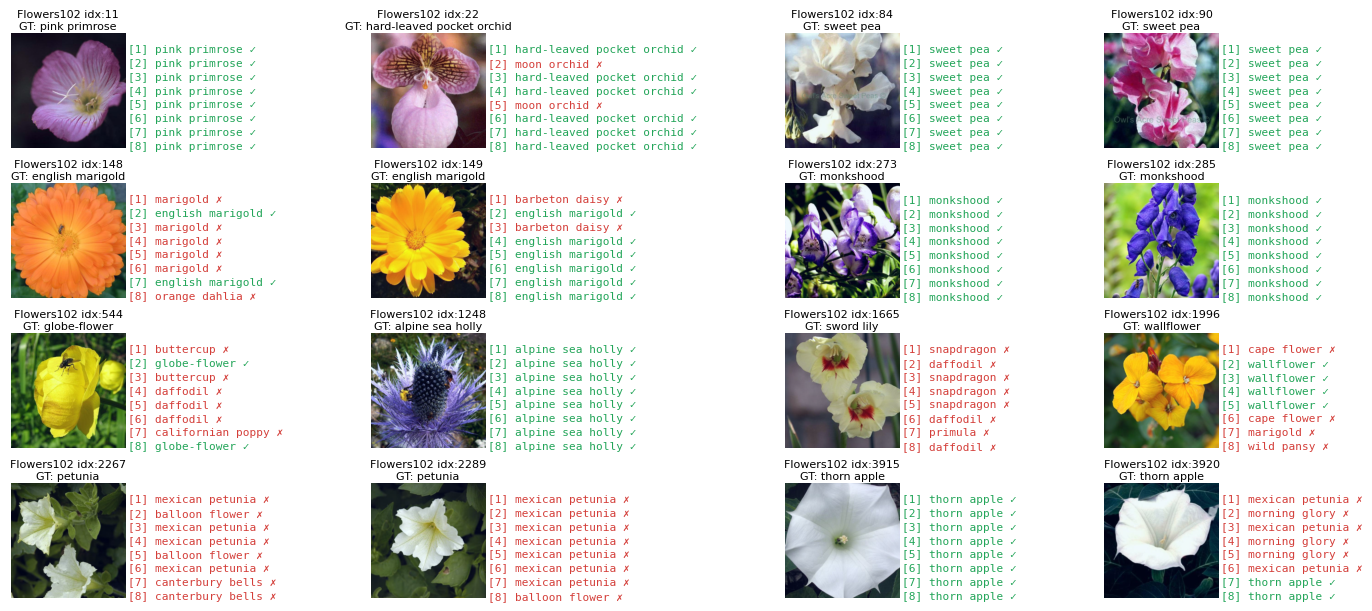

In [65]:

visualize_multi_prompt_compact_indices(
    flowers102_test_dts,        
    flowers102_class_names,     
    prompt_templates,           
    indices=[11, 22, 84, 90, 148, 149, 273, 285, 544, 1248, 1665, 1996, 2267, 2289, 3915, 3920],
    num_images=16,
    cols=4,
    dataset_name="Flowers102"
)


/tmp/ipykernel_1178260/2419210879.py:132: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.8, hspace=0.05)


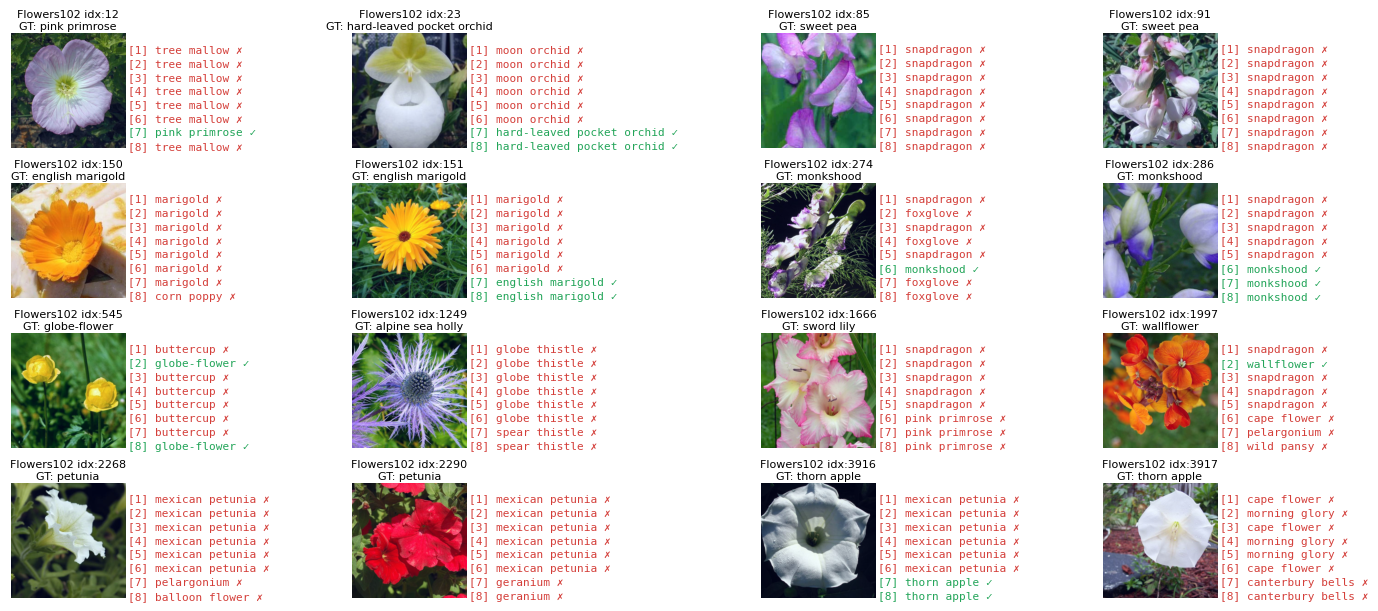

In [63]:

visualize_multi_prompt_compact_indices(
    flowers102_test_dts,        
    flowers102_class_names,     
    prompt_templates,           
    indices=[12, 23, 85, 91, 150, 151, 274, 286, 545, 1249, 1666, 1997, 2268, 2290, 3916, 3917],
    num_images=16,
    cols=4,
    dataset_name="Flowers102"
)


Birds

/tmp/ipykernel_1178260/2419210879.py:132: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.8, hspace=0.05)


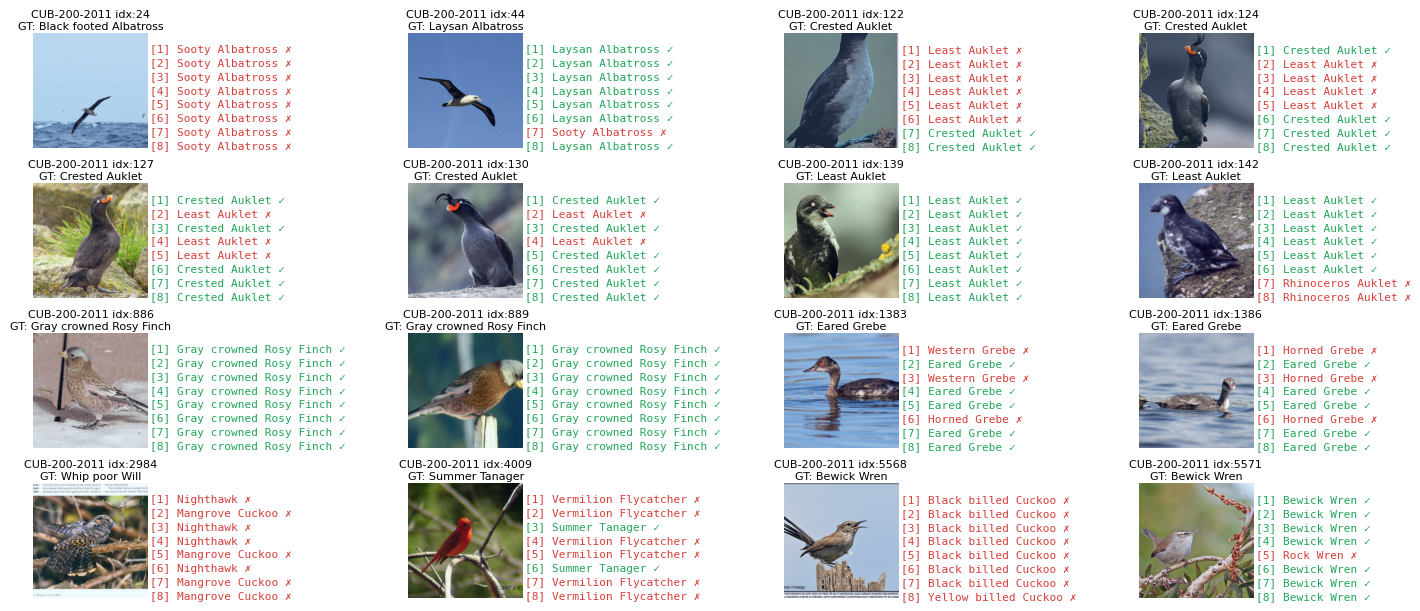

In [66]:
# 顯示 16 張鳥類圖片 (可指定索引或隨機)
visualize_multi_prompt_compact_indices(
    cub_bird_test_dts,          # HF dataset
    cub_bird_class_names,
    prompt_templates,
    indices=[24, 44, 122, 124, 127, 130, 139, 142, 886, 889, 1383, 1386, 2984, 4009, 5568, 5571],
    num_images=16,
    cols=4,
    dataset_name="CUB-200-2011"
)


/tmp/ipykernel_1178260/2419210879.py:132: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.8, hspace=0.05)


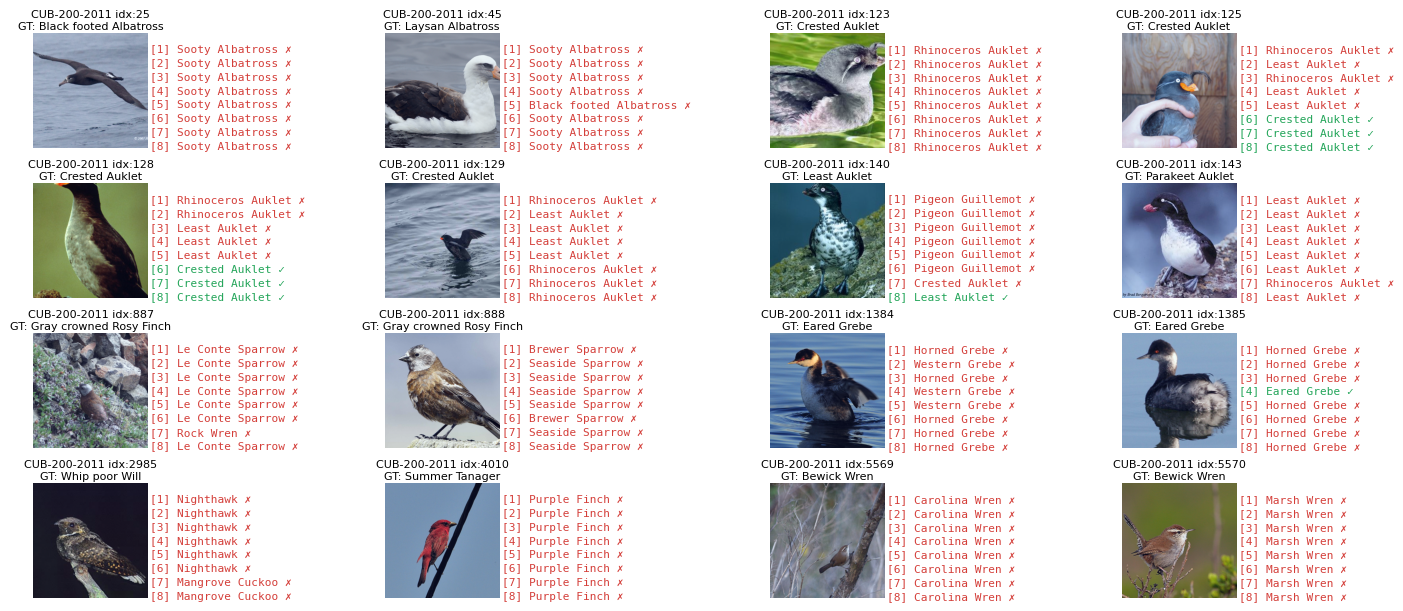

In [61]:
# 顯示 16 張鳥類圖片 (可指定索引或隨機)
visualize_multi_prompt_compact_indices(
    cub_bird_test_dts,          # HF dataset
    cub_bird_class_names,
    prompt_templates,
    indices=[25, 45, 123, 125, 128, 129, 140, 143, 887, 888, 1384, 1385, 2985, 4010, 5569, 5570],
    num_images=16,
    cols=4,
    dataset_name="CUB-200-2011"
)
